# Sign Language Translator using MediaPipe

## Installing the dependencies

In [1]:
%pip install opencv-python
%pip install mediapipe
%pip install pandas
%pip install scikit-learn==1.4.2
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [1]:
import cv2
import mediapipe as mp
import csv
import random
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


## Test Mediapipe

### Type 1

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def draw_hand_landmarks(image, hand_landmarks, hand_connections, hand_label):
    for connection in hand_connections:
        start_index = connection[0]
        end_index = connection[1]
        start_landmark = hand_landmarks.landmark[start_index]
        end_landmark = hand_landmarks.landmark[end_index]
        start_point = (int(start_landmark.x * image.shape[1]), int(start_landmark.y * image.shape[0]))
        end_point = (int(end_landmark.x * image.shape[1]), int(end_landmark.y * image.shape[0]))
        # Gambar edge dengan warna hijau
        cv2.line(image, start_point, end_point, (0, 255, 0), 2)

    for landmark in hand_landmarks.landmark:
        landmark_point = (int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0]))
        # Gambar vertex dengan warna merah
        cv2.circle(image, landmark_point, 3, (0, 0, 255), -1)

        # Tampilkan keterangan koordinat di sebelah vertex
        cv2.putText(image, f'({landmark_point[0]}, {landmark_point[1]})', landmark_point, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

def get_hand_coordinates(image, holistic):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)

    left_hand_coords = []
    right_hand_coords = []

    if results.left_hand_landmarks:
        draw_hand_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 'L')
        left_hand_coords = [(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
    if results.right_hand_landmarks:
        draw_hand_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 'R')
        right_hand_coords = [(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]

    return left_hand_coords + right_hand_coords

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))

        coordinates = get_hand_coordinates(frame, holistic)

        cv2.imshow('Hand Landmarks', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


c:\ProgramData\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


### Type 2

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def draw_hand_landmarks(image, hand_landmarks, hand_connections, hand_label):
    mp_drawing.draw_landmarks(
        image, hand_landmarks, hand_connections,
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)
    )
    for idx, landmark in enumerate(hand_landmarks.landmark):
        height, width, _ = image.shape
        cx, cy = int(landmark.x * width), int(landmark.y * height)
        cv2.putText(image, f'{hand_label}_{idx}', (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

def get_hand_coordinates(image, holistic):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)

    left_hand_coords = []
    right_hand_coords = []

    if results.left_hand_landmarks:
        draw_hand_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 'L')
        left_hand_coords = [(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
    if results.right_hand_landmarks:
        draw_hand_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 'R')
        right_hand_coords = [(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]

    return left_hand_coords + right_hand_coords

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))

        coordinates = get_hand_coordinates(frame, holistic)

        cv2.imshow('Hand Landmarks', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Record Data

### With Coordinate

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def record_hand_landmarks(class_data, augmentation_factor=5):
    cap = cv2.VideoCapture(0)
    holistic = mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3)

    with open('dataset.csv', mode='w', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        header = ['class']
        for i in range(21):
            header += [f'x{i+1}', f'y{i+1}', f'z{i+1}']
        for i in range(21):
            header += [f'xr{i+1}', f'yr{i+1}', f'zr{i+1}']
        csv_writer.writerow(header)

        for class_name, num_samples in class_data.items():
            print(f"Recording data for class '{class_name}'...")
            data = 0
            while data < num_samples:
                ret, frame = cap.read()
                if not ret:
                    break
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.flip(image, 1)
                image.flags.writeable = False
                results = holistic.process(image)
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                row = [class_name]
                if results.left_hand_landmarks:
                    lh = [(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
                else:
                    lh = [(0.0, 0.0, 0.0)] * 21

                if results.right_hand_landmarks:
                    rh = [(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]
                else:
                    rh = [(0.0, 0.0, 0.0)] * 21

                row += [coord for lm in lh for coord in lm]
                row += [coord for lm in rh for coord in lm]

                for _ in range(augmentation_factor):
                    augmented_row = [coord + random.uniform(-0.05, 0.05) if isinstance(coord, float) else coord for coord in row]
                    csv_writer.writerow(augmented_row)

                # Draw landmarks and connections, and add vertex labels
                if results.left_hand_landmarks:
                    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                                              mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2))
                    for idx, landmark in enumerate(results.left_hand_landmarks.landmark):
                        coords = (int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0]))
                        cv2.putText(image, f'{idx}', coords, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                if results.right_hand_landmarks:
                    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                                              mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2))
                    for idx, landmark in enumerate(results.right_hand_landmarks.landmark):
                        coords = (int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0]))
                        cv2.putText(image, f'{idx}', coords, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                cv2.imshow('Recording', image)

                if cv2.waitKey(10) & 0xFF == ord('x'):
                    break

                data += 1

            print(f"Paused. Press any key to continue to the next class.")
            cv2.waitKey(0)

    cap.release()
    cv2.destroyAllWindows()

    print("Recording for all classes has been completed.")

class_data_huruf = {char: 50 for char in string.ascii_uppercase}

record_hand_landmarks(class_data_huruf)

Recording data for class 'A'...


c:\ProgramData\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Paused. Press any key to continue to the next class.
Recording data for class 'B'...
Paused. Press any key to continue to the next class.
Recording data for class 'C'...
Paused. Press any key to continue to the next class.
Recording data for class 'D'...
Paused. Press any key to continue to the next class.
Recording data for class 'E'...
Paused. Press any key to continue to the next class.
Recording data for class 'F'...
Paused. Press any key to continue to the next class.
Recording data for class 'G'...
Paused. Press any key to continue to the next class.
Recording data for class 'H'...
Paused. Press any key to continue to the next class.
Recording data for class 'I'...
Paused. Press any key to continue to the next class.
Recording data for class 'J'...
Paused. Press any key to continue to the next class.
Recording data for class 'K'...
Paused. Press any key to continue to the next class.
Recording data for class 'L'...
Paused. Press any key to continue to the next class.
Recording da

### Simple

In [2]:
import cv2
import csv
import mediapipe as mp
import string

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils


def record_hand_landmarks(class_data, augmentation_factor=5):
    cap = cv2.VideoCapture(0)
    holistic = mp_holistic.Holistic(
        min_detection_confidence=0.3, min_tracking_confidence=0.3)

    with open('dataset.csv', mode='w', newline='') as f:
        csv_writer = csv.writer(
            f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        header = ['class']
        for i in range(21):
            header += [f'x{i+1}', f'y{i+1}', f'z{i+1}']
        for i in range(21):
            header += [f'xr{i+1}', f'yr{i+1}', f'z{i+1}']
        csv_writer.writerow(header)

        for class_name, num_samples in class_data.items():
            print(f"Recording data for class '{class_name}'...")
            data = 0
            while data < num_samples:
                ret, frame = cap.read()
                if not ret:
                    break
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image = cv2.flip(image, 1)
                image.flags.writeable = False
                results = holistic.process(image)
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                row = [class_name]

                lh = [(0.0, 0.0, 0.0)] * 21
                rh = [(0.0, 0.0, 0.0)] * 21

                if results.left_hand_landmarks:
                    lh = [(lm.x, lm.y, lm.z)
                          for lm in results.left_hand_landmarks.landmark]

                if results.right_hand_landmarks:
                    rh = [(lm.x, lm.y, lm.z)
                          for lm in results.right_hand_landmarks.landmark]

                row += [coord for lm in lh for coord in lm]
                row += [coord for lm in rh for coord in lm]

                if results.left_hand_landmarks or results.right_hand_landmarks:
                    csv_writer.writerow(row)
                    data += 1
                    print(f"Recorded sample {data}/{num_samples} for class '{class_name}'")

                # Draw landmarks and connections, simple with green lines and red dots
                drawing_spec_landmark = mp_drawing.DrawingSpec(
                    color=(0, 0, 255), thickness=2, circle_radius=2)
                drawing_spec_connection = mp_drawing.DrawingSpec(
                    color=(0, 255, 0), thickness=2, circle_radius=2)

                if results.left_hand_landmarks:
                    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              drawing_spec_landmark, drawing_spec_connection)

                if results.right_hand_landmarks:
                    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                              drawing_spec_landmark, drawing_spec_connection)

                cv2.imshow('Recording', image)

                if cv2.waitKey(10) & 0xFF == ord('x'):
                    break

            print(f"Paused. Press any key to continue to the next class.")
            cv2.waitKey(0)

    cap.release()
    cv2.destroyAllWindows()

    print("Recording for all classes has been completed.")


class_data_huruf = {char: 1250 for char in string.ascii_uppercase}

record_hand_landmarks(class_data_huruf)


Recording data for class 'A'...


c:\ProgramData\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Recorded sample 1/1250 for class 'A'
Recorded sample 2/1250 for class 'A'
Recorded sample 3/1250 for class 'A'
Recorded sample 4/1250 for class 'A'
Recorded sample 5/1250 for class 'A'
Recorded sample 6/1250 for class 'A'
Recorded sample 7/1250 for class 'A'
Recorded sample 8/1250 for class 'A'
Recorded sample 9/1250 for class 'A'
Recorded sample 10/1250 for class 'A'
Recorded sample 11/1250 for class 'A'
Recorded sample 12/1250 for class 'A'
Recorded sample 13/1250 for class 'A'
Recorded sample 14/1250 for class 'A'
Recorded sample 15/1250 for class 'A'
Recorded sample 16/1250 for class 'A'
Recorded sample 17/1250 for class 'A'
Recorded sample 18/1250 for class 'A'
Recorded sample 19/1250 for class 'A'
Recorded sample 20/1250 for class 'A'
Recorded sample 21/1250 for class 'A'
Recorded sample 22/1250 for class 'A'
Recorded sample 23/1250 for class 'A'
Recorded sample 24/1250 for class 'A'
Recorded sample 25/1250 for class 'A'
Recorded sample 26/1250 for class 'A'
Recorded sample 27/12

## Training Data

### Read Data

In [3]:
# Reading the dataset from CSV file
data = pd.read_csv('dataset.csv')

# Displaying some initial rows of the dataset for verification
data.head()


,class,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18.1,xr19,yr19,z19.1,xr20,yr20,z20.1,xr21,yr21,z21.1
0,A,0.860104,0.442100,-4.184189e-07,0.849949,0.368245,0.021133,0.818119,0.319664,0.028124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,0.800624,0.261245,-2.847240e-07,0.792020,0.216977,0.040872,0.770907,0.182261,0.060159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,0.797213,0.256265,-4.188475e-08,0.792815,0.218322,0.035757,0.771556,0.186619,0.053216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,0.867360,0.555975,-5.775883e-07,0.832565,0.598451,-0.004308,0.798143,0.618567,-0.011884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,0.914797,0.602029,-6.168965e-07,0.876511,0.606399,0.002280,0.841516,0.600426,0.000172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Displaying Data Counts for Each Class

In [4]:
# Displaying data counts for each class sorted from A to Z
class_counts = data['class'].value_counts().sort_index()
print("Data counts for each class (sorted from A to Z):")
print(class_counts)


Data counts for each class (sorted from A to Z):
A    1250
B    1250
C    1250
D    1250
E    1250
F    1250
G    1250
H    1250
I    1250
J    1250
K    1250
L    1250
M    1250
N    1250
O    1250
P    1250
Q    1250
R    1250
S    1250
T    1250
U    1250
V    1250
W    1250
X    1250
Y    1250
Z    1250
Name: class, dtype: int64


### Separating Features and Labels

In [5]:
# Separating features and labels
X = data.drop('class', axis=1)
y = data['class']

# Verifying the shape of X and y
X.shape, y.shape


((32500, 126), (32500,))

### Splitting Data into Training and Testing Sets

In [6]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Verifying the shape of training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((26000, 126), (6500, 126), (26000,), (6500,))

### Creating and Training Random Forest Model

In [7]:
# Creating Random Forest Classifier model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Predicting on test data

In [8]:
y_pred = rf_clf.predict(X_test)

#### Evaluating the Model

In [9]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.996
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       234
           B       1.00      1.00      1.00       236
           C       0.99      1.00      1.00       262
           D       1.00      0.99      0.99       247
           E       1.00      1.00      1.00       253
           F       1.00      1.00      1.00       241
           G       1.00      0.99      0.99       255
           H       1.00      1.00      1.00       267
           I       1.00      1.00      1.00       243
           J       1.00      1.00      1.00       269
           K       0.99      1.00      1.00       244
           L       1.00      1.00      1.00       264
           M       0.99      0.98      0.99       249
           N       0.98      0.99      0.99       246
           O       0.99      1.00      0.99       249
           P       1.00      1.00      1.00       260
           Q       1.00      1.00      1.0

#### Displaying Confusion Matrix

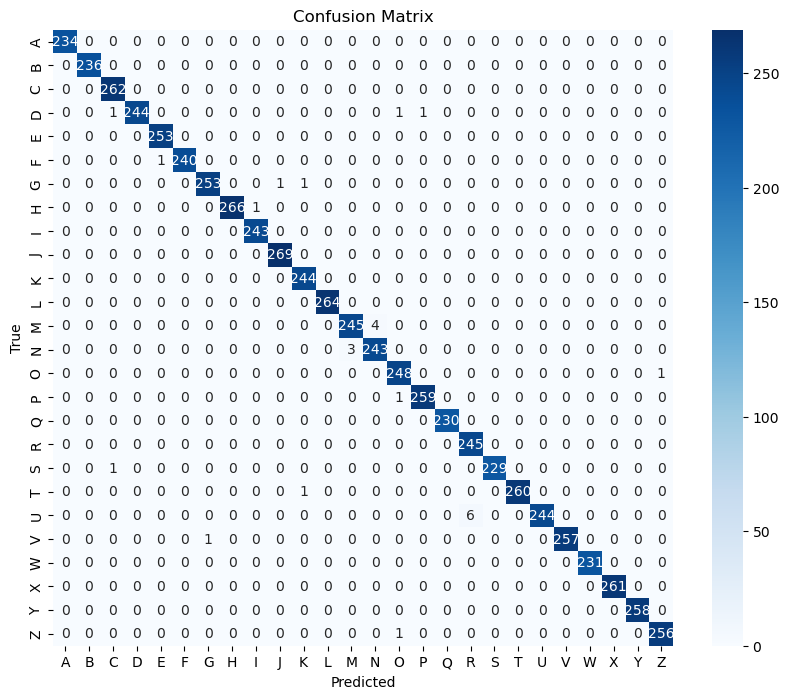

In [10]:
# Displaying confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Splitting Data into Training and Testing Sets

In [11]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

# Verifying the shape of training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((19500, 126), (13000, 126), (19500,), (13000,))

### Creating and Training Random Forest Model

In [12]:
# Creating Random Forest Classifier model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Predicting on test data

In [14]:
y_pred = rf_clf.predict(X_test)

#### Evaluating the Model

In [15]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.9942307692307693
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       492
           B       1.00      0.98      0.99       506
           C       0.99      1.00      1.00       525
           D       1.00      0.99      0.99       489
           E       0.97      1.00      0.99       480
           F       0.99      0.99      0.99       487
           G       1.00      0.99      0.99       526
           H       1.00      0.98      0.99       507
           I       0.98      1.00      0.99       513
           J       0.99      1.00      0.99       504
           K       1.00      1.00      1.00       514
           L       1.00      1.00      1.00       524
           M       0.99      0.99      0.99       496
           N       0.99      0.99      0.99       464
           O       1.00      0.99      1.00       495
           P       0.99      1.00      1.00       508
           Q       1.00      

#### Displaying Confusion Matrix

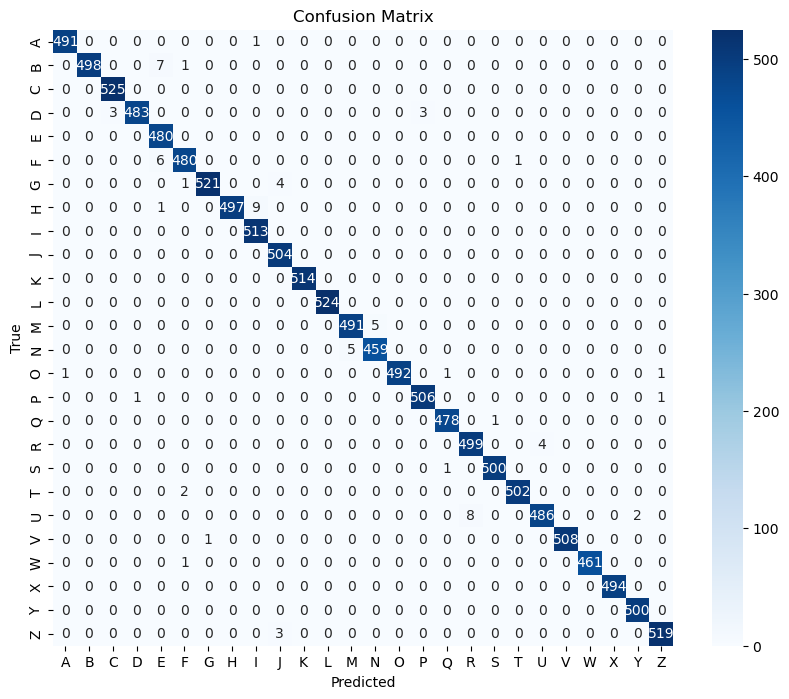

In [16]:
# Displaying confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Saving the Model

In [17]:
joblib.dump(rf_clf, "hand_gesture_model.sav")


['hand_gesture_model.sav']

## Testing the Prediction Before Deploy

In [18]:

# Load the trained model
model = joblib.load('hand_gesture_model.sav')

# Initialize MediaPipe Holistic and Drawing
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Function to capture and predict hand gestures
def capture_and_predict():
    cap = cv2.VideoCapture(0)
    holistic = mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.3)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.flip(image, 1)
        image.flags.writeable = False

        # Process the image with MediaPipe
        results = holistic.process(image)

        # Set image back to writable and convert back to BGR for OpenCV
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw the hand landmarks
        if results.left_hand_landmarks:
            mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        if results.right_hand_landmarks:
            mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Prepare data for prediction
        lh = [(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark] if results.left_hand_landmarks else [(0.0, 0.0, 0.0)] * 21
        rh = [(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark] if results.right_hand_landmarks else [(0.0, 0.0, 0.0)] * 21

        # Flatten the landmark lists
        row = [coord for lm in lh for coord in lm] + [coord for lm in rh for coord in lm]
        row = np.array(row).reshape(1, -1)

        # Predict the class
        class_name = model.predict(row)[0]

        # Display the prediction on the frame
        cv2.putText(image, f'Class: {class_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Show the image
        cv2.imshow('Hand Gesture Prediction', image)

        # Break the loop if 'x' is pressed
        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    capture_and_predict()

c:\ProgramData\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni